In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import numpy as np
from read_data import read_enhanced_microscore_dataset
from plots import first_plot, second_plot, third_plot, forth_plot, plot_performance, fith_plot
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

In [14]:
df = read_enhanced_microscore_dataset()


In [15]:
df_base = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "Metros",
    # "CodigoPostal",
    "Latitud",
    "Longitud",
    'Caracteristicas'
]]

In [16]:
df_microscore = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "Metros",
    # "CodigoPostal",
    "Latitud",
    "Longitud",
    "RentaBrutaHogar",
    "RentaBrutaPersona",
    "poblacion_2023",
    "%_servicios",
    "densidad_inm_m2",
    "%_agricultura",
    "%_industria",
    "%_construccion",
    'Caracteristicas',
    'University_Distance',
    'School_Distance', 'Kindergarten_Distance', 'City Center_Distance',
       'Supermarket_Distance', 'Bakery_Distance', 'Hospital_Distance',
       'Pharmacy_Distance', 'Restaurant_Distance', 'Café_Distance',
       'Park_Distance', 'Gym_Distance', 'Movie Theater_Distance',
       'Theater_Distance', 'Shopping Mall_Distance', 'Bus Stop_Distance',
       'Metro Station_Distance', 'Score'
]]

In [17]:
def prepare_data(df):
    categorical_cols = ['Caracteristicas']
    df = pd.get_dummies(df, columns=categorical_cols)
    return df

In [18]:
df_base =prepare_data(df_base)
df_microscore =prepare_data(df_microscore)

In [19]:
def xgboost_grid(df):
    X = df.drop(columns=['Precio'])
    y = df['Precio']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
    
    # XGBoost Regressor
    xgb_model = XGBRegressor(random_state=42)
    
    # GridSearchCV parametros
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring=scorer,
        cv=2,  # 3-fold cross-validation
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_  
    
    print(best_params) 
    print(best_score)

In [20]:
xgboost_grid(df_microscore)

Fitting 2 folds for each of 243 candidates, totalling 486 fits



KeyboardInterrupt



In [21]:
def xgboost_kfold(df, params):
    X = df.drop(columns=["Precio"])  
    y = df["Precio"]  
    
    kf = KFold(n_splits=5, shuffle=True, random_state=56)
    
    mae_list = []
    rmse_list = []
    mape_list = []
    
    # 5-fold cross validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Escalado
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Entrenamiento XGBoost model
        xgb_model = XGBRegressor(**params, random_state=56)
        xgb_model.fit(X_train_scaled, y_train, 
                      eval_set=[(X_test_scaled, y_test)], 
                      verbose=False)
        
        # Prediccion
        y_pred = xgb_model.predict(X_test_scaled)
        
        # Calculo metricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        mae_list.append(mae)
        rmse_list.append(rmse)
        mape_list.append(mape)
        
        print(f"Fold MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
    
    print("\n--- Metricas Cross-Validation ---")
    print(f"Average MAE: {np.mean(mae_list):.2f}")
    print(f"Average RMSE: {np.mean(rmse_list):.2f}")
    print(f"Average MAPE: {np.mean(mape_list):.2%}")
    
    X_scaled = scaler.fit_transform(X)
    xgb_model = XGBRegressor(**params, random_state=56)
    xgb_model.fit(X_scaled, y)
    
    return xgb_model, X_scaled, y_test, y_pred


In [22]:
# Mejores parametros
params = {
            "n_estimators": 200,
            "learning_rate": 0.1,
            "max_depth": 9,
            "subsample": 1,
            "colsample_bytree": 0.6
        }

final_model, X_scaled, y_test_base, y_pred_base = xgboost_kfold(df_base, params)

Fold MAE: 57401.79, RMSE: 137136.89, MAPE: 26.95%
Fold MAE: 56733.66, RMSE: 129971.36, MAPE: 26.42%
Fold MAE: 58168.26, RMSE: 146377.77, MAPE: 26.80%
Fold MAE: 55948.09, RMSE: 128582.75, MAPE: 25.99%
Fold MAE: 56780.03, RMSE: 130850.26, MAPE: 26.67%

--- Cross-Validation Metrics ---
Average MAE: 57006.37
Average RMSE: 134583.81
Average MAPE: 26.57%


In [23]:
# Mejores parametros
params = {
    "n_estimators": 200,
    "learning_rate": 0.1,
    "max_depth": 9,
    "subsample": 1,
    "colsample_bytree": 0.6
}

final_model, X_scaled, y_test_micro, y_pred_micro = xgboost_kfold(df_microscore, params)

Fold MAE: 53775.23, RMSE: 132915.68, MAPE: 24.65%
Fold MAE: 52572.41, RMSE: 124404.84, MAPE: 24.33%
Fold MAE: 53763.07, RMSE: 144242.94, MAPE: 24.66%
Fold MAE: 51436.82, RMSE: 118154.24, MAPE: 23.96%
Fold MAE: 51948.98, RMSE: 118665.56, MAPE: 24.50%

--- Cross-Validation Metrics ---
Average MAE: 52699.30
Average RMSE: 127676.65
Average MAPE: 24.42%


In [24]:
feature_importance = pd.DataFrame({
    'Feature': df_microscore.drop(columns=["Precio"]).columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                         Feature  Importance
9              RentaBrutaPersona    0.148723
1                          Aseos    0.130523
34     Caracteristicas_Apartment    0.087228
11                   %_servicios    0.073897
12               densidad_inm_m2    0.073647
3                        Piscina    0.063778
5                         Metros    0.058961
32        Metro Station_Distance    0.034925
8                RentaBrutaHogar    0.034105
13                 %_agricultura    0.025516
7                       Longitud    0.021879
10                poblacion_2023    0.020913
6                        Latitud    0.020709
0                   Habitaciones    0.017909
16           University_Distance    0.012107
14                   %_industria    0.011890
30        Shopping Mall_Distance    0.011156
15                %_construccion    0.010783
19          City Center_Distance    0.010226
28        Movie Theater_Distance    0.010044
36         Caracteristicas_House    0.009988
29        

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_blue = df_plot_base.groupby("log_bin")["%error"].mean().reset_index()
C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_red = df_plot__micro.groupby("log_bin")["%error"].mean().reset_index()


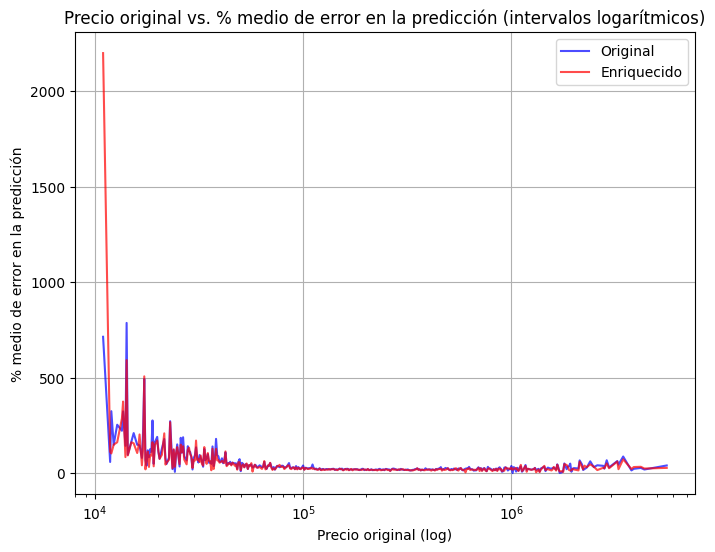

In [25]:
fith_plot(y_test_base, y_pred_base, y_test_micro, y_pred_micro)